# Введение
В данном ноутбуке представлен мой вариант решения домашнего задания по спринту #7 (ML).

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from typing import Callable, List
from datetime import datetime

In [2]:
classification_data_path = Path("./classification/predictive_maintenance.csv")
regression_data_path = Path("./regression/train.csv")

In [3]:
plt.style.use('seaborn-v0_8')

## Задание 1 - выбор датасета

Для задачи регрессии использовался датасет с данными о потреблении электроэнергии (Electricity Consumption). По различным свойствам, таким как скорость ветра, температура воздуха и т.д., необходимо предсказать уровень потребления. Больше о наборе данных можно узнать на https://www.kaggle.com/datasets/utathya/electricity-consumption.

Для задачи классификации использовался датасет с данными о выходе из строя оборудования на производстве. Необходимо по различным характеристикам оборудования определить, нуждается ли оно в осмотре. Больше можно узнать на https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification.

## Задание 2 - загрузка данных с помощью pandas

Загрузим данные классификации и регрессии средствами pandas

In [4]:
classification_data = pd.read_csv(classification_data_path)
regression_data = pd.read_csv(regression_data_path)

В данных есть лишние столбцы (например, Target и Failure Type - это одно и то же). Предобработку сделаем позже.

In [5]:
classification_data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [6]:
regression_data.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


## Задание 3 - визуализация

### Классификация

#### Setup

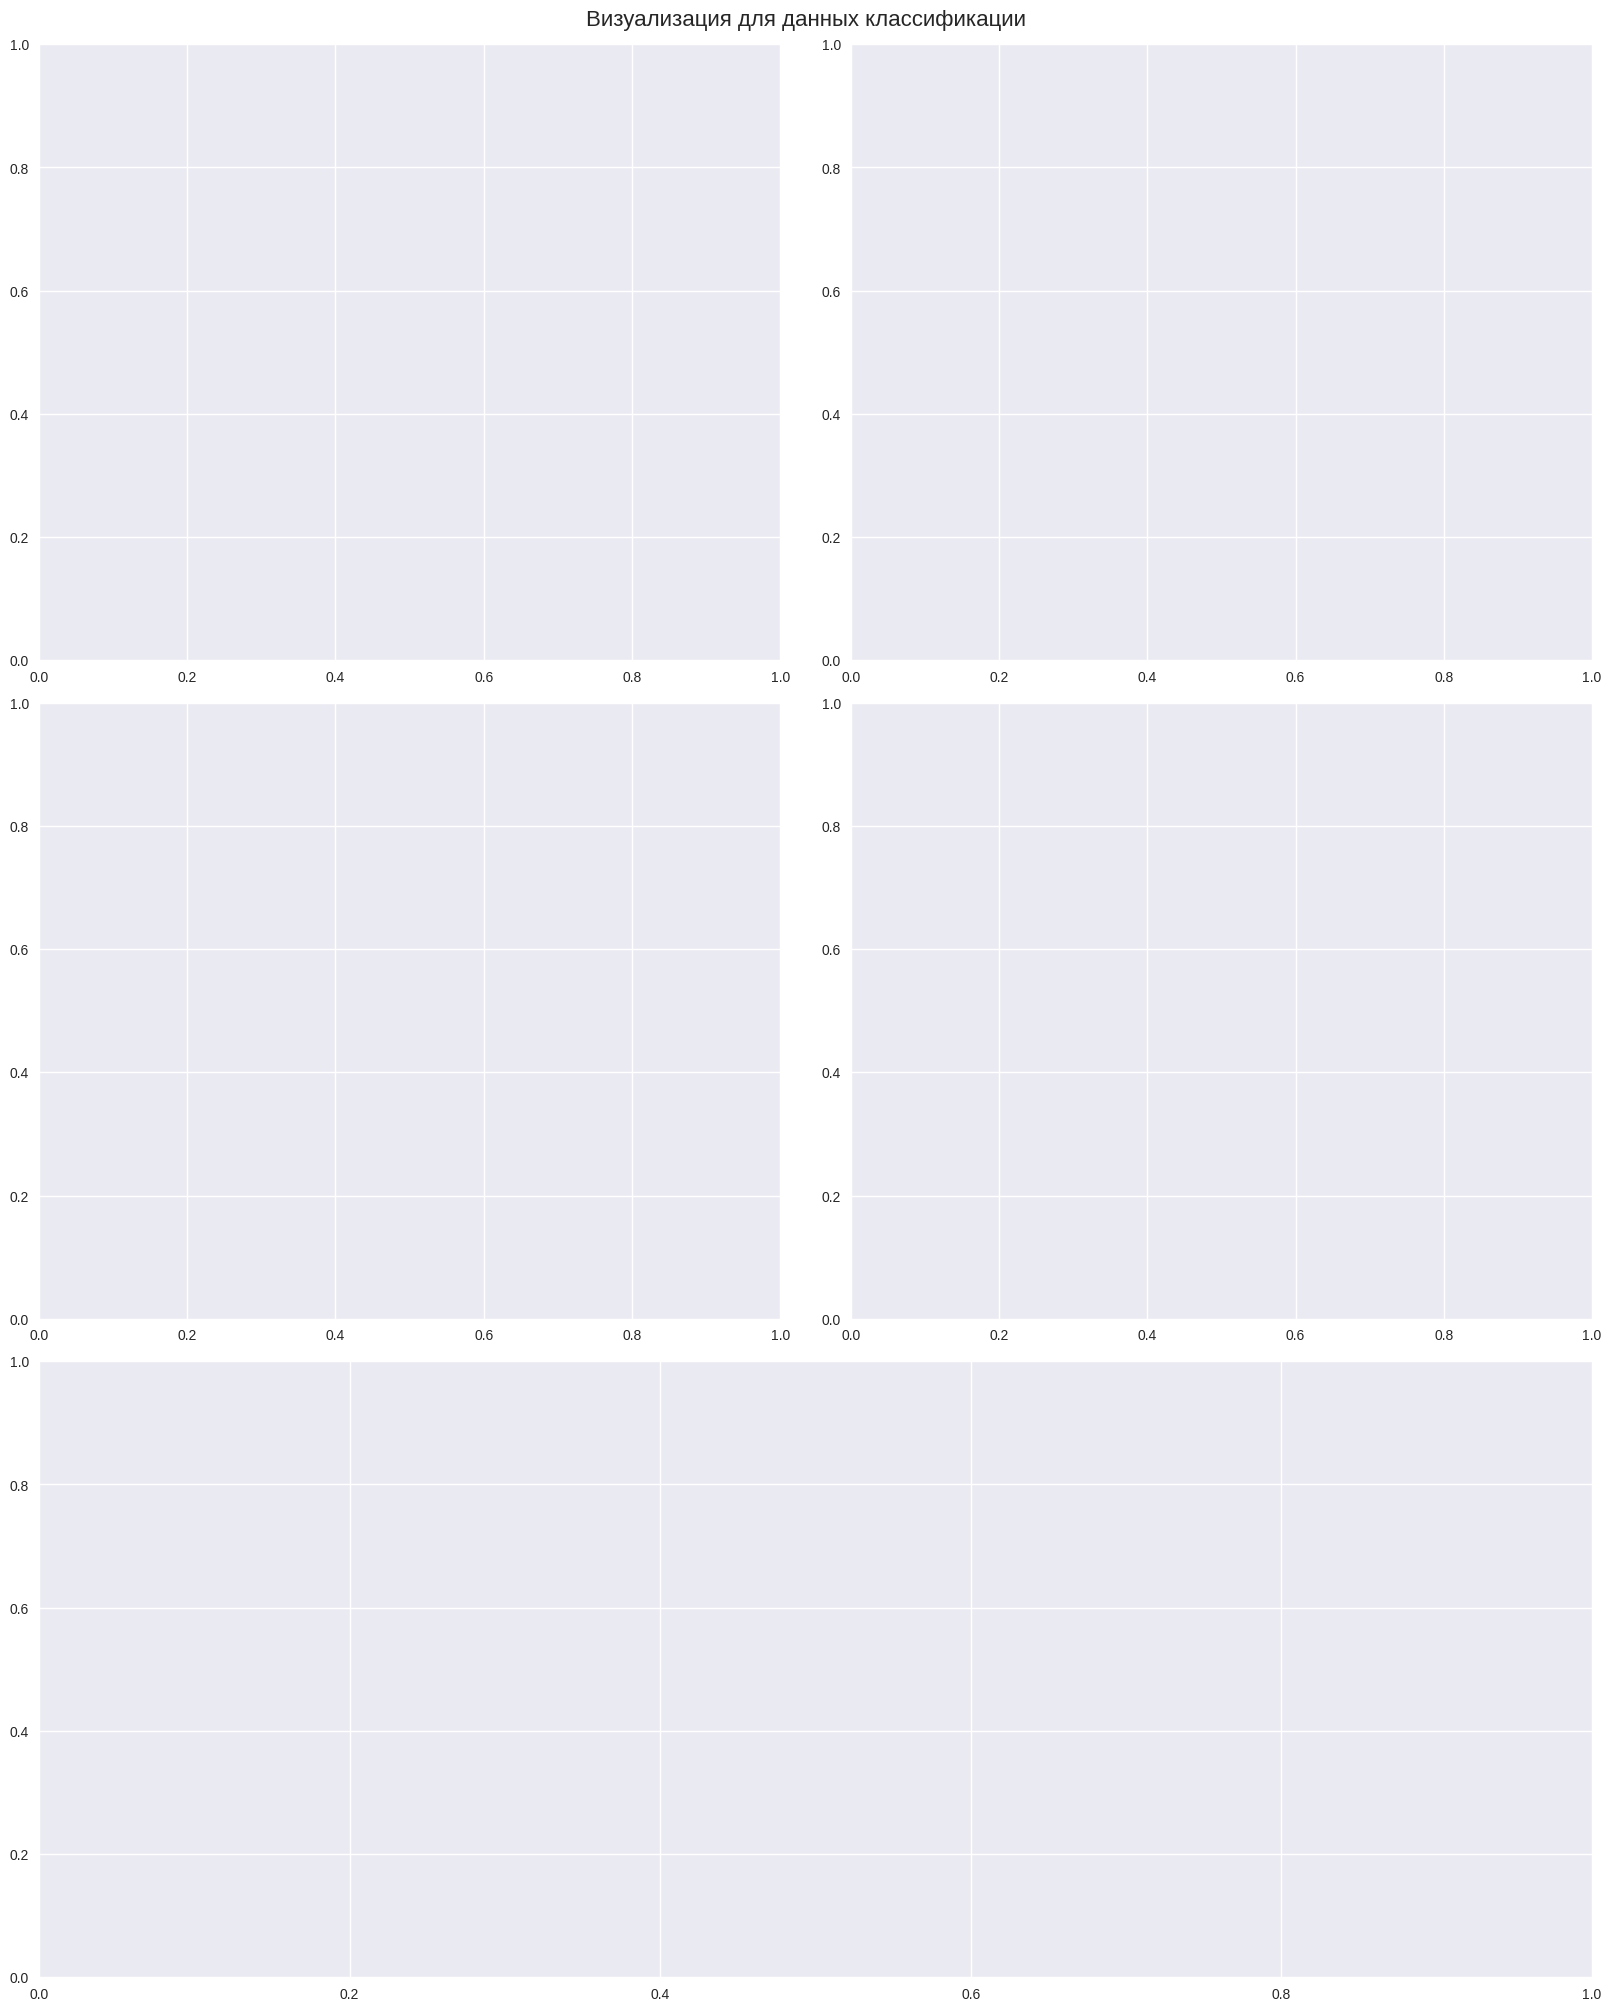

In [7]:
fig_class, axes_class = plt.subplot_mosaic([['1', '2'], ['3', '4'], ['5', '5']],
                              constrained_layout=True, figsize=(16,20))

fig_class.suptitle('Визуализация для данных классификации', fontsize=16);

#### Уровни качества

In [8]:
labels, counts = np.unique(classification_data['Type'], return_counts=True)

In [9]:
labels[np.where(labels == 'H')] = 'Высокое качество'
labels[np.where(labels == 'L')] = 'Низкое quality'
labels[np.where(labels == 'M')] = 'Среднее качество'

In [10]:
axes_class['1'].set_title('Уровни качества продукции', fontsize=12);
axes_class['1'].pie(counts, labels=labels, shadow = True);

#### Зависимость температуры работы от температуры воздуха
Увидим, что зависимость практически линейная.

In [11]:
axes_class['2'].set_title('Температура работы от температуры воздуха', fontsize=12);
axes_class['2'].set_xlabel('Температура воздуха');
axes_class['2'].set_ylabel('Температура работы');
axes_class['2'].scatter(
                        classification_data['Air temperature [K]'], 
                        classification_data['Process temperature [K]'],
                        alpha=0.5
                    );

#### Распределение скоростей вращения оборудования
Напоминает распределение Пуассона.

In [12]:
axes_class['3'].set_title('Распределение скоростей вращения оборудования', fontsize=12)
axes_class['3'].set_xlabel('Скорость вращения');
axes_class['3'].set_ylabel('Число фиксирований');

axes_class['3'].hist(classification_data['Rotational speed [rpm]'], bins=12);

#### Распределение времени работы оборудования до сбоя

После поломки оборудование чинят и износ (колонка 'Tool wear [min]') обнуляется. Посмотрим на статистику работы оборудования до износа.

In [13]:
class_stats = classification_data['Tool wear [min]'][classification_data['Target'] == 1]
class_stats.reset_index(drop= True , inplace= True )

На графике видно, что outlier'ов не наблюдается.

In [14]:
axes_class['4'].set_ylabel('Время работы оборудования до поломки');
sns.boxplot(ax=axes_class['4'], data=class_stats);

#### Построим временной ряд износа оборудования, чтобы примерно понять природу его переодичности
Для наглядности возьмём лишь первые 2000 значений.

In [15]:
x = classification_data['UDI'].values[:2000]
y = classification_data['Tool wear [min]'].values[:2000]
axes_class['5'].set_title('Периодичность износа оборудования', fontsize=12);
axes_class['5'].set_xlabel('Номер фиксации данных');
axes_class['5'].set_ylabel('Износ оборудования в минутах');
axes_class['5'].plot(x, y);

#### Наконец, выведем графики:

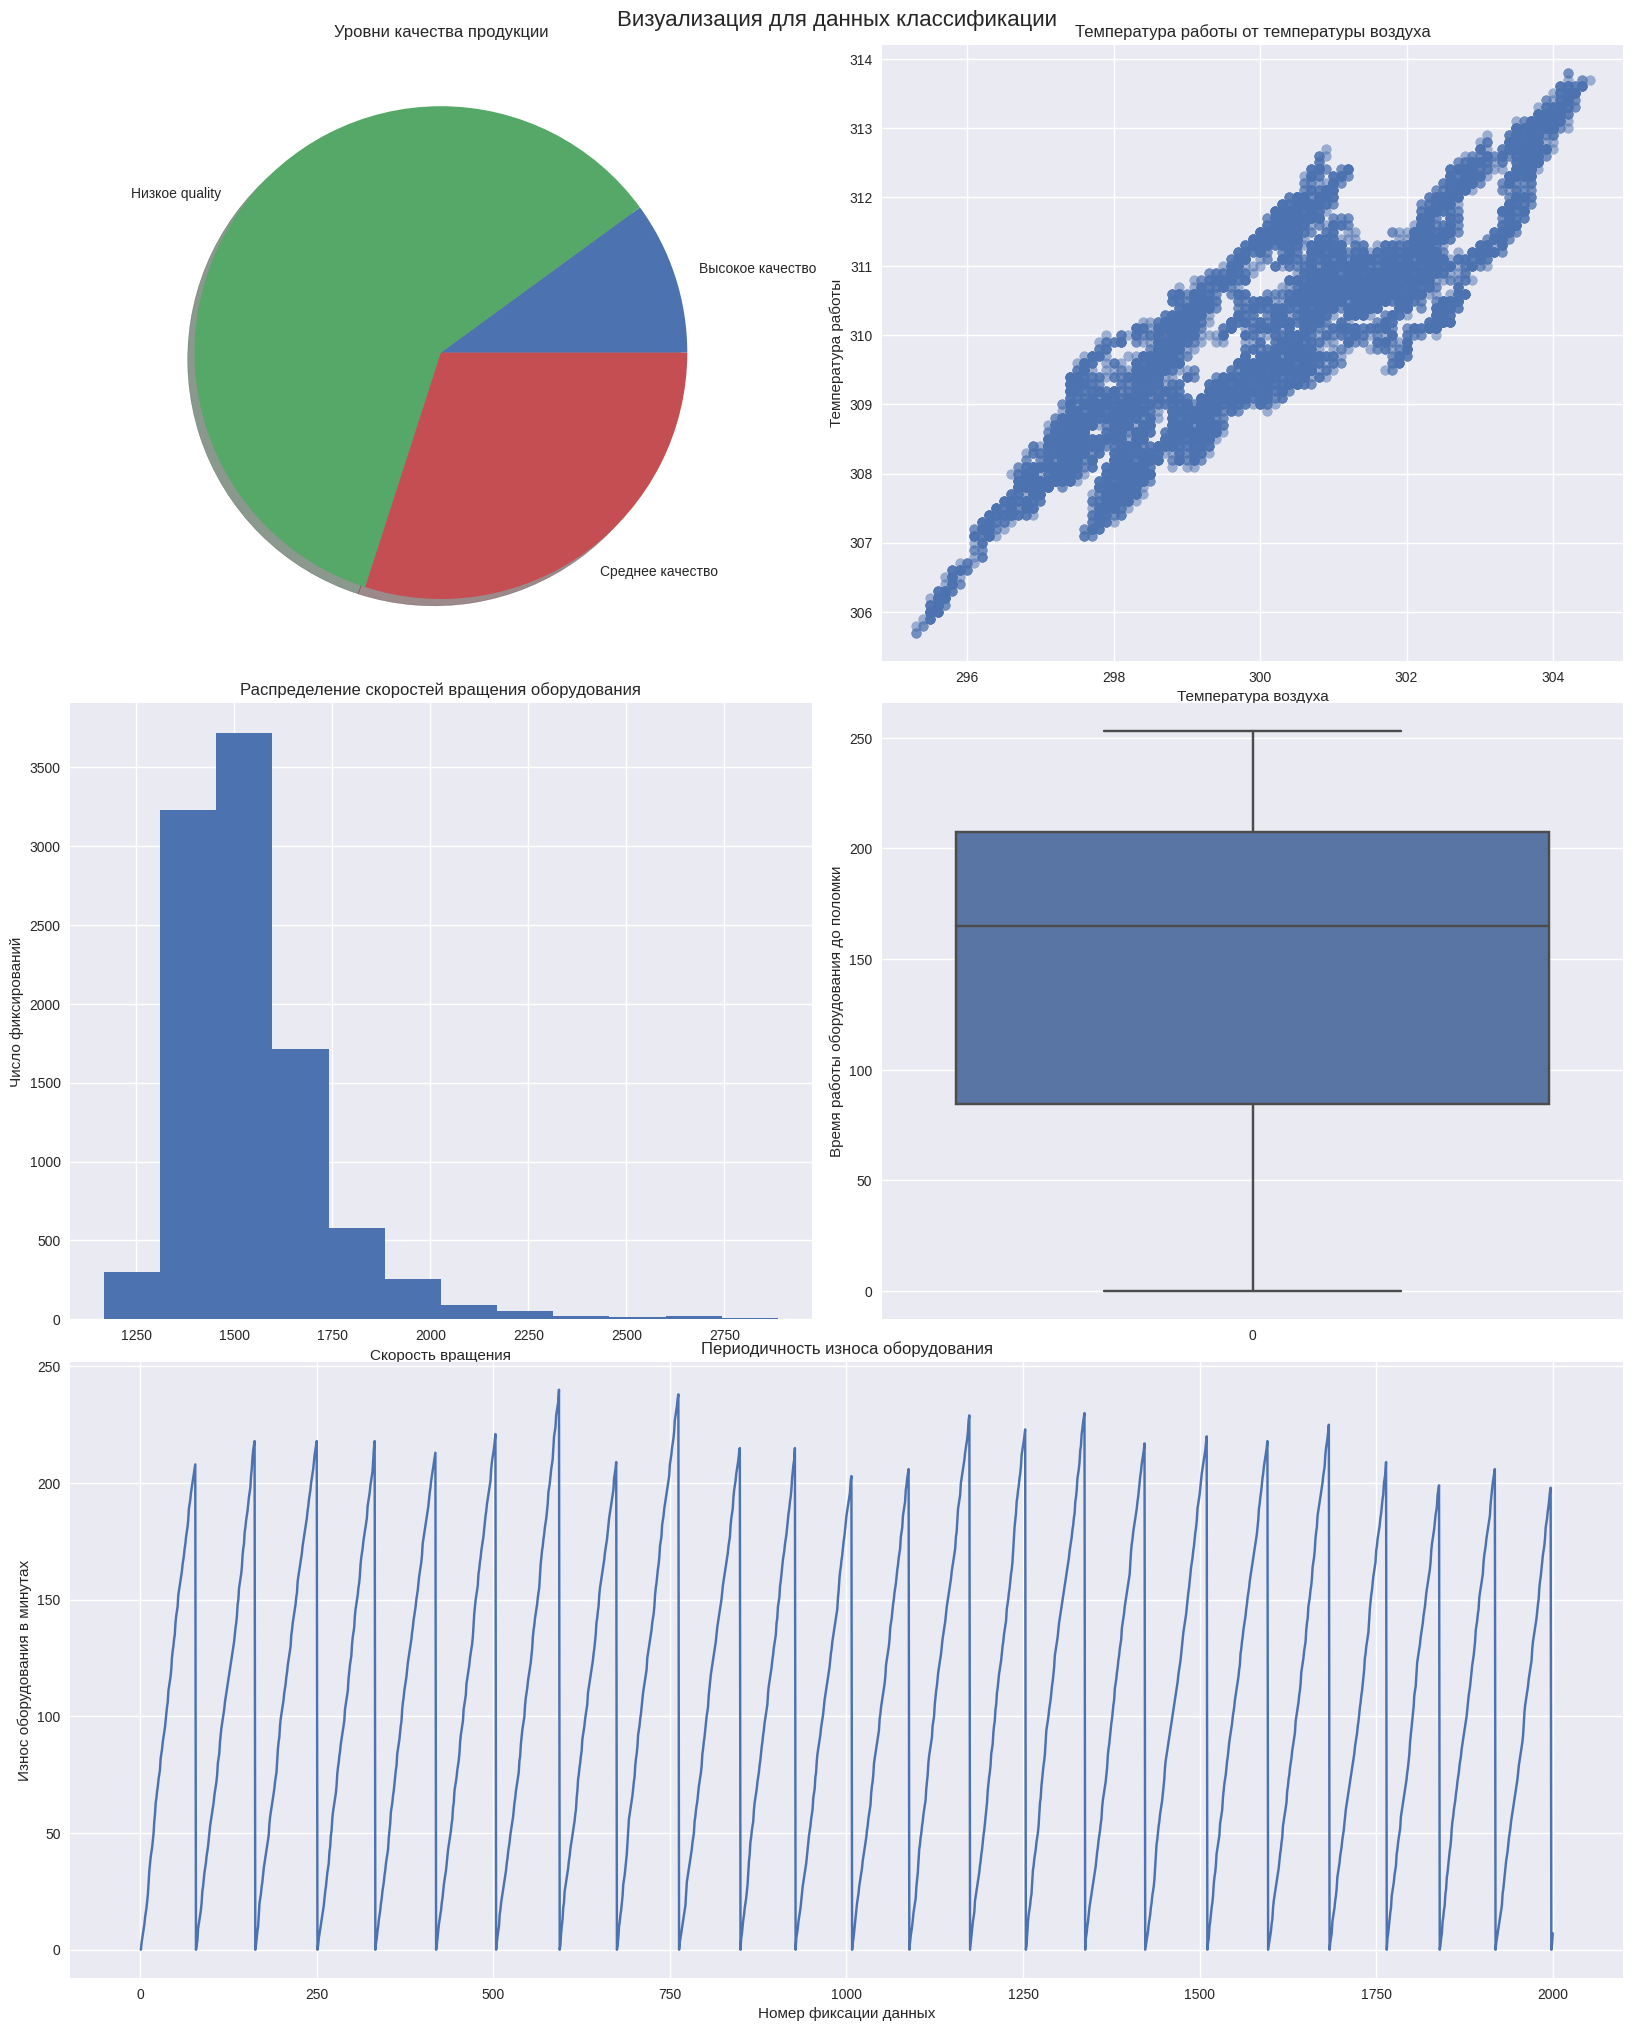

In [16]:
fig_class

### Регрессия

#### Setup

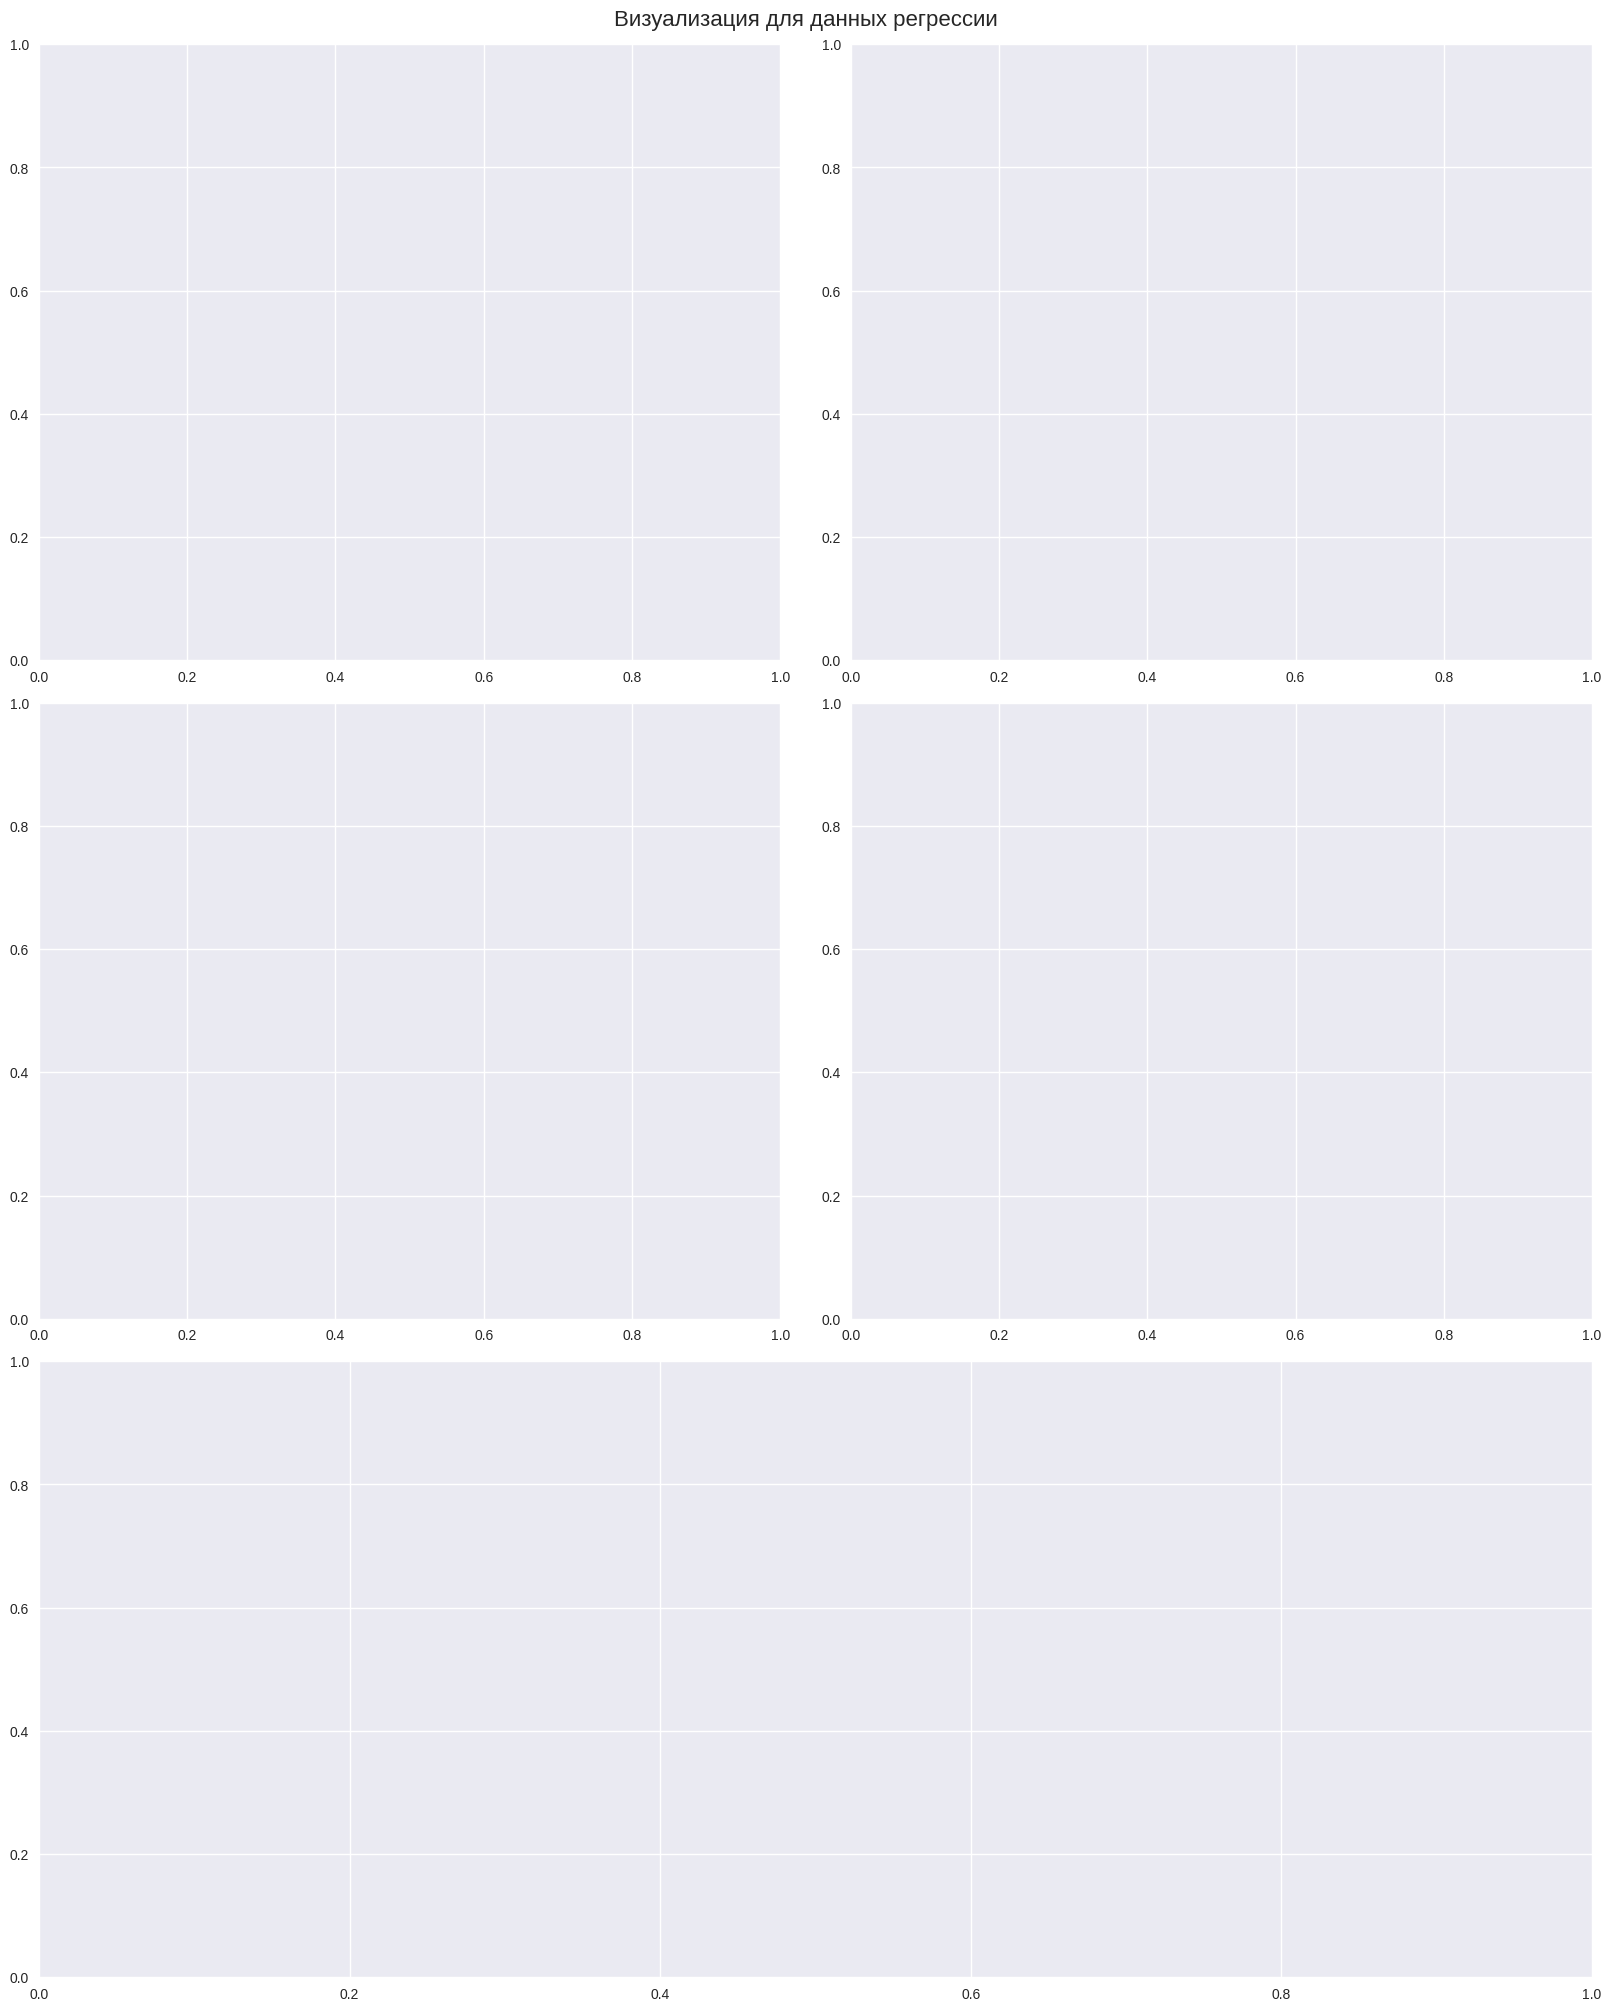

In [17]:
fig_regr, axes_regr = plt.subplot_mosaic([['1', '2'], ['3', '4'], ['5', '5']],
                              constrained_layout=True, figsize=(16,20))

fig_regr.suptitle('Визуализация для данных регрессии', fontsize=16);

#### Посмотрим, не было ли за всё время фиксирования счётчиков аномальных значений давления
Их не так много.

In [18]:
axes_regr['1'].set_ylabel('Показатели давления');
sns.boxplot(ax=axes_regr['1'], data=regression_data['pressure']);

#### Переменные var1 и var2
Не совсем понятно, что обозначает переменные var2 и var1, поэтому изучим их подробнее 

#### Распределение var2

In [19]:
labels, counts = np.unique(regression_data['var2'], return_counts=True)

In [20]:
axes_regr['2'].set_title('var2', fontsize=12);
axes_regr['2'].pie(counts, labels=labels, shadow = True);

#### Попробуем узнать среднее значение по тэгам var2
Выделяется только для 'B'.

In [21]:
stats_var2 = regression_data.groupby(['var2'])['electricity_consumption'].mean()

In [22]:
axes_regr['3'].set_title('Средние значения при группировке по var2', fontsize=12);
axes_regr['3'].set_xlabel('Среднее значение потребления');
stats_var2.plot(kind='barh', ax = axes_regr['3']);

#### Попробуем понять зависимость потребления от var1
Линейной зависимости не наблюдается

In [23]:
axes_regr['4'].set_title('Потребление от var1', fontsize=12);
axes_regr['4'].set_xlabel('var1');
axes_regr['4'].set_ylabel('Потребление');
axes_regr['4'].scatter(
                        regression_data['var1'], 
                        regression_data['electricity_consumption'],
                        alpha=0.5
                    );

#### Проанализируем временной ряд
Мы можем видеть аномальные значения потребления 

In [24]:
x = regression_data['ID'].values[:2000]
y = regression_data['electricity_consumption'].values[:2000]
axes_regr['5'].set_title('Временной ряд', fontsize=12);
axes_regr['5'].set_xlabel('Номер фиксации');
axes_regr['5'].set_ylabel('Потребление');
axes_regr['5'].plot(x, y);

#### Наконец, визуализация

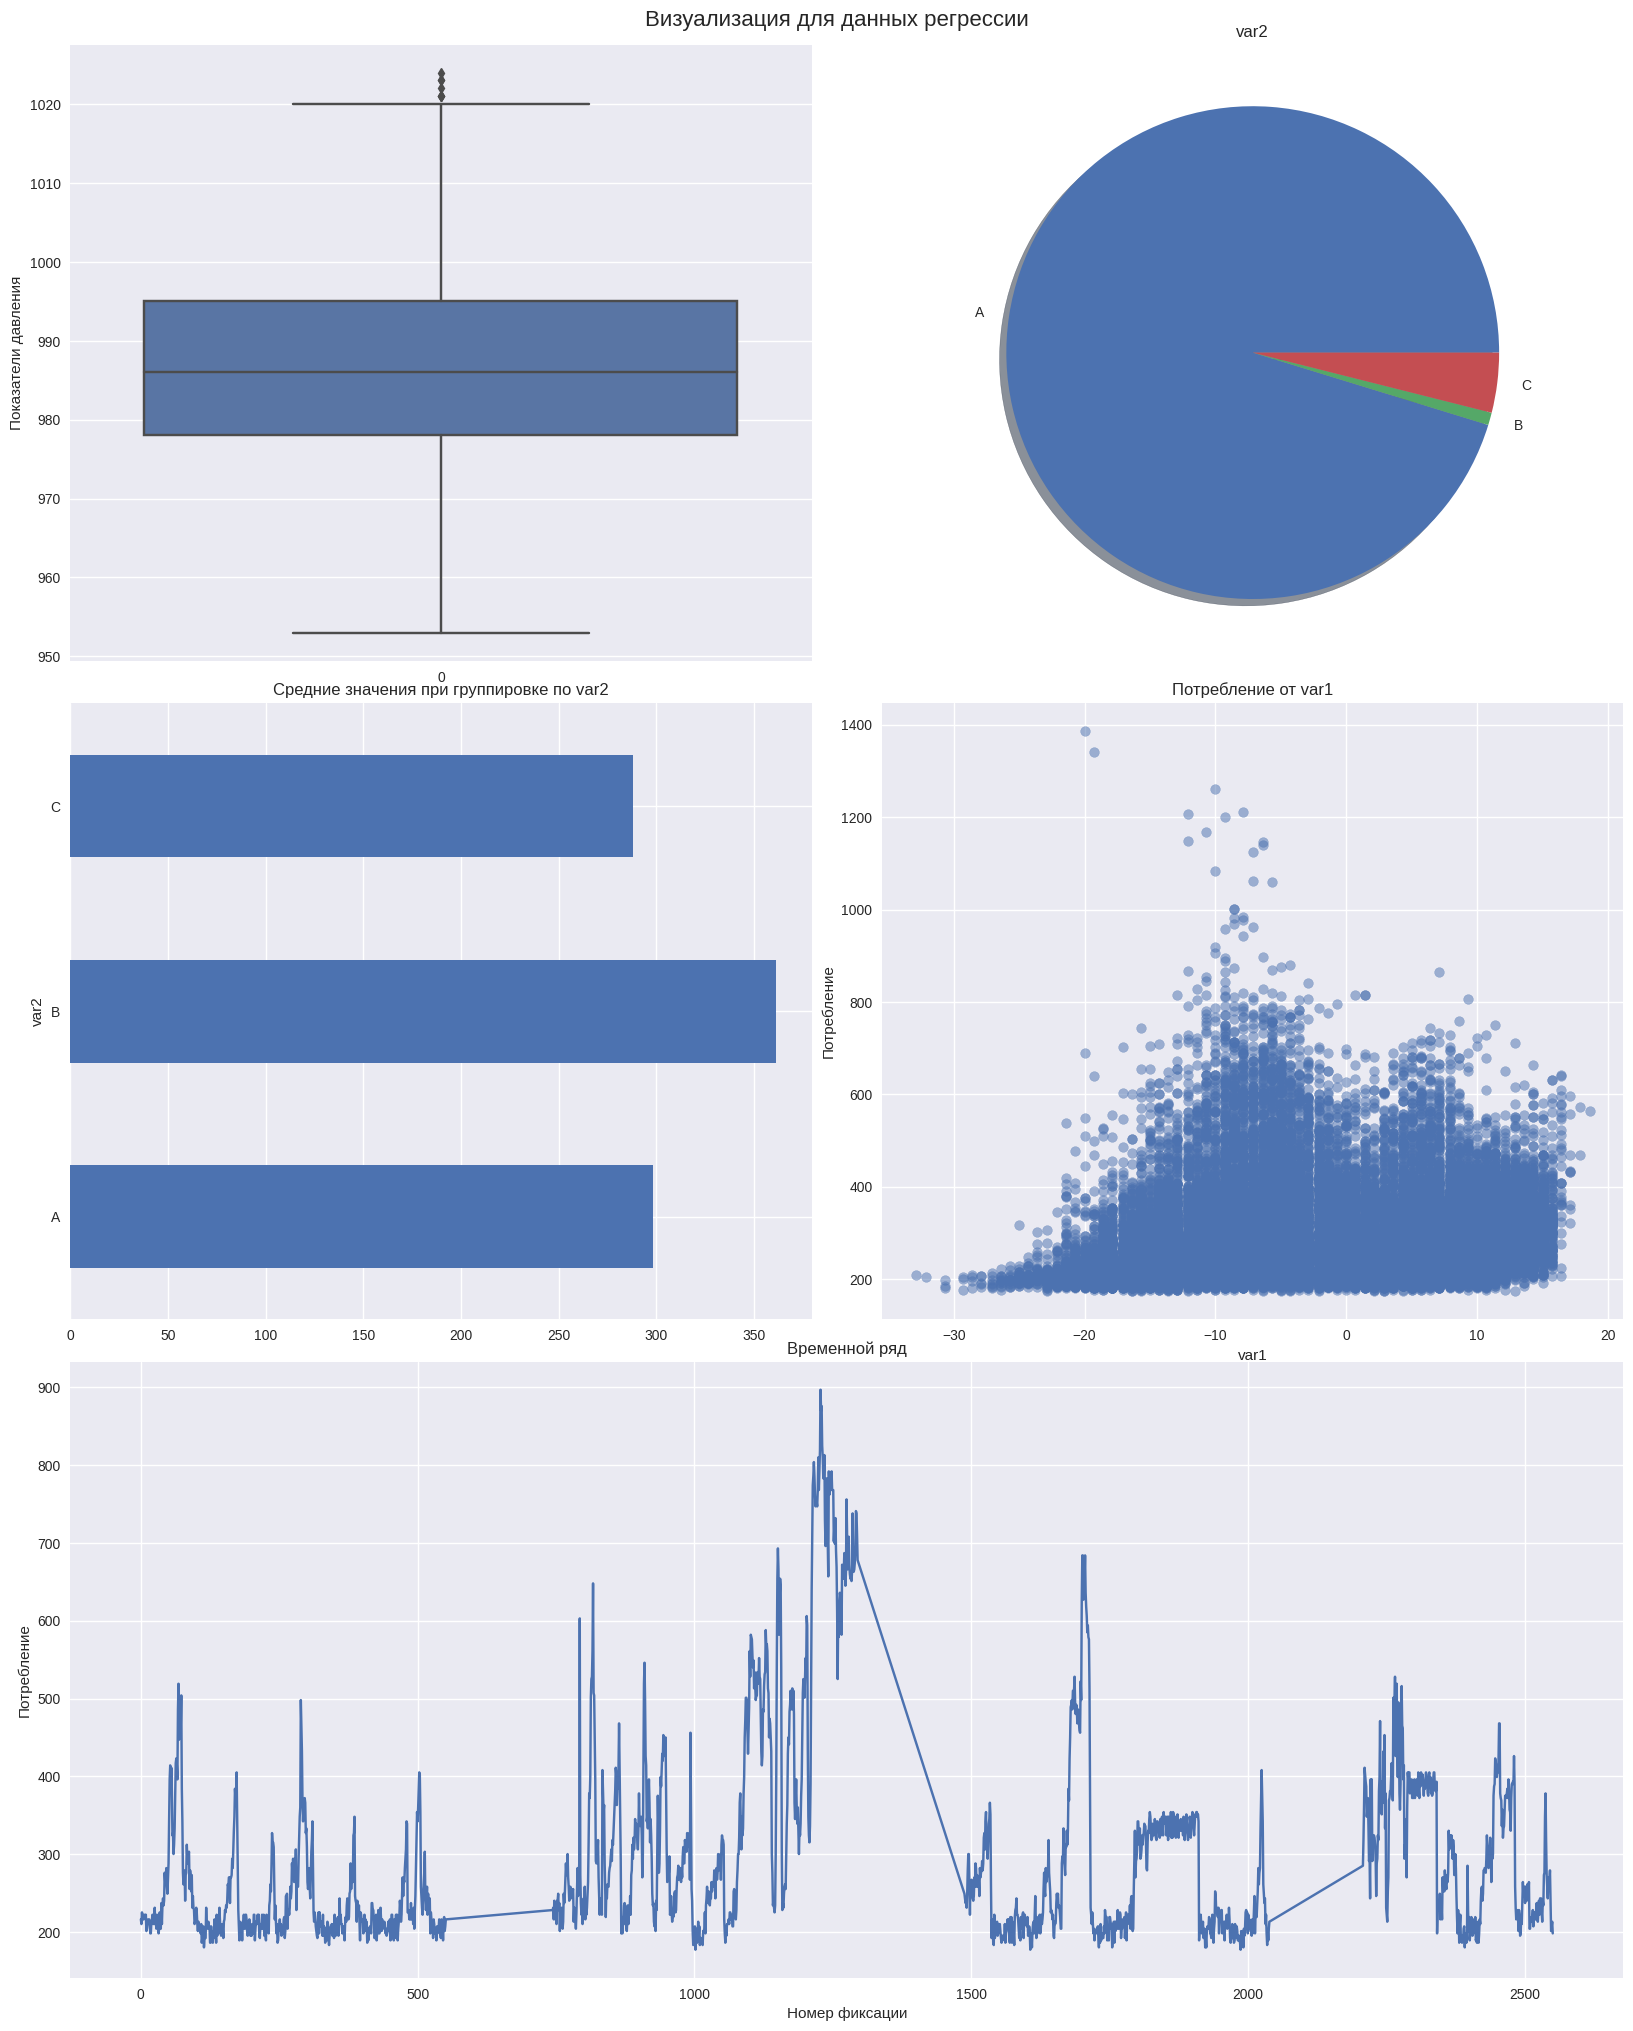

In [25]:
fig_regr

## Задание 4 - предобработка

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

###  Классификация

In [27]:
classification_data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


#### Удаление
Удалим бесполезные: 'UDI', 'Product ID', 'Failure Type'.

Также удалим 'Air temperature' из-за сильной коррелированности с 'Process temperature' (См. выше в визуализации).

In [28]:
classification_data.drop(['UDI', 'Product ID', 'Failure Type', 'Air temperature [K]'], axis=1, inplace=True)

In [29]:
classification_data.head()

,Type,Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,M,308.6,1551,42.8,0,0
1,L,308.7,1408,46.3,3,0
2,L,308.5,1498,49.4,5,0
3,L,308.6,1433,39.5,7,0
4,L,308.7,1408,40.0,9,0


Пропусков, как видим, нет

In [30]:
classification_data.isnull().sum()

Type                       0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
dtype: int64

#### Приведём категориальные признаки к вещественным
Type: ['L', 'M', 'H'] -> [1, 2, 3]. Не будем выводить их в отдельные колонки, так как числовые значения здесь имеют смысл (Low - самый низкий, High - самый высокий)

In [31]:
cat_features = ['Type']
prefixes = ['type']

In [32]:
classification_data = pd.get_dummies(columns=cat_features, data=classification_data, prefix=prefixes)

In [33]:
classification_data.head()

,Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,type_H,type_L,type_M
0,308.6,1551,42.8,0,0,0,0,1
1,308.7,1408,46.3,3,0,0,1,0
2,308.5,1498,49.4,5,0,0,1,0
3,308.6,1433,39.5,7,0,0,1,0
4,308.7,1408,40.0,9,0,0,1,0


#### Разделим на признаки и целевые значения

In [34]:
classification_data_proportion = 0.80

In [35]:
X_classification = classification_data.loc[:, classification_data.columns != 'Target'].values

In [36]:
Y_classification = classification_data['Target'].values

In [37]:
X_train_classification, X_test_classification, Y_train_classification, Y_test_classification = train_test_split( X_classification,
                                                                                                                 Y_classification,
                                                                                                                 stratify=Y_classification,
                                                                                                                 test_size=(1-classification_data_proportion) )

In [38]:
scaler_classification = StandardScaler()
X_train_classification = scaler_classification.fit_transform(X_train_classification)
X_test_classification = scaler_classification.transform(X_test_classification)

С датасетом классификации на этом всё.

###  Регрессия

In [39]:
regression_data.head(7)

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0
5,5,2013-07-01 05:00:00,-10.7,-19.3,1013.0,2.790,A,216.0
6,6,2013-07-01 06:00:00,-13.6,-17.1,1006.0,4.380,A,219.0


Сразу удаляем лишнюю колонку ID.

In [40]:
regression_data.drop(['ID'], axis=1, inplace=True)

Пустых ячеек в таблице нет.

In [41]:
regression_data.isnull().sum()

datetime                   0
temperature                0
var1                       0
pressure                   0
windspeed                  0
var2                       0
electricity_consumption    0
dtype: int64

#### Добавление

Если посмотреть на временной ряд в визуализации, то можно понять, что потребление электричества довольно периодично. Предположительно, происходит так из-за низкого потребления энергии ночью и утром и высокого - днём и вечером. Аналогично, потребление на выходных будет больше, чем в будние дни. Поэтому есть смымысл выделить из даты необходимую информацию о времени суток и дне недели.

#### Время

In [42]:
# Преобразуем regression_data['datetime'] к типу datetime
time_pattern = '%Y-%m-%d %H:%M:%S'

regression_data['datetime'] = regression_data.apply(
                            lambda row: datetime.strptime(row['datetime'], time_pattern),
                            axis = 1
                        )
isinstance(regression_data['datetime'].values[0], np.datetime64)

True

##### Часть дня:
День, ночь, вечер, утро.

In [43]:
def day_part(hour: int) -> int:
    if  4 <= hour <= 11:
        return 1
    elif 12 <= hour <= 16:
        return 2
    elif 17 <= hour <= 23:
        return 3
    else:
        return 4

In [44]:
regression_data['day_part'] = regression_data.apply(
                            lambda row: day_part(pd.to_datetime(row['datetime']).hour),
                            axis = 1
                        )
regression_data[['datetime', 'day_part']].head(10)

,datetime,day_part
0,2013-07-01 00:00:00,4
1,2013-07-01 01:00:00,4
2,2013-07-01 02:00:00,4
3,2013-07-01 03:00:00,4
4,2013-07-01 04:00:00,1
5,2013-07-01 05:00:00,1
6,2013-07-01 06:00:00,1
7,2013-07-01 07:00:00,1
8,2013-07-01 08:00:00,1
9,2013-07-01 09:00:00,1


День недели

In [45]:
regression_data['day'] = regression_data.apply(
                            lambda row: pd.to_datetime(row['datetime']).weekday() + 1,
                            axis = 1
                        )

Сам столбец datetime удалим.

In [46]:
regression_data.drop(['datetime'], axis=1, inplace=True)
regression_data.head()

,temperature,var1,pressure,windspeed,var2,electricity_consumption,day_part,day
0,-11.4,-17.1,1003.0,571.910,A,216.0,4,1
1,-12.1,-19.3,996.0,575.040,A,210.0,4,1
2,-12.9,-20.0,1000.0,578.435,A,225.0,4,1
3,-11.4,-17.1,995.0,582.580,A,216.0,4,1
4,-11.4,-19.3,1005.0,586.600,A,222.0,1,1


#### Преобразуем категориальный призак var2

In [47]:
cat_features = ['var2', 'day_part', 'day']
prefixes = ['var2', 'day_part', 'day']

In [48]:
regression_data = pd.get_dummies(columns=cat_features, data=regression_data, prefix=prefixes)

In [49]:
regression_data.head()

,temperature,var1,pressure,windspeed,electricity_consumption,var2_A,var2_B,var2_C,day_part_1,day_part_2,day_part_3,day_part_4,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,-11.4,-17.1,1003.0,571.910,216.0,1,0,0,0,0,0,1,1,0,0,0,0,0,0
1,-12.1,-19.3,996.0,575.040,210.0,1,0,0,0,0,0,1,1,0,0,0,0,0,0
2,-12.9,-20.0,1000.0,578.435,225.0,1,0,0,0,0,0,1,1,0,0,0,0,0,0
3,-11.4,-17.1,995.0,582.580,216.0,1,0,0,0,0,0,1,1,0,0,0,0,0,0
4,-11.4,-19.3,1005.0,586.600,222.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0


#### Выделим признаки и целевые значения

In [50]:
regression_data_proportion = 0.85

In [51]:
X_regression = regression_data.loc[:, regression_data.columns != 'electricity_consumption'].values

In [52]:
Y_regression = regression_data['electricity_consumption'].values

In [53]:
X_train_regression, X_test_regression, Y_train_regression, Y_test_regression = train_test_split( X_regression,
                                                                                                 Y_regression,
                                                                                                 test_size=0.2 )

In [54]:
scaler_regression = StandardScaler()
X_train_regression = scaler_regression.fit_transform(X_train_regression)
X_test_regression = scaler_regression.transform(X_test_regression)

## Задание 5 - обучение моделей

In [55]:
from sklearn.model_selection import GridSearchCV  # для варьирования параметров

### Классификация
Обучим три модели: 
1) Опорные векторы (SVM) - мощный линейный алгоритм классификации.
2) Логистическая регрессия - ещё один линейный алгоритм классификации с интерпретацией выхода как апостериорной вероятности. 
3) Случайный Лес - Bagging над решающими деревьями.

In [56]:
from sklearn.metrics import confusion_matrix, classification_report, r2_score

#### SVM
Будем варьировать параметр C - коэффициент регуляризации.

In [57]:
from sklearn.svm import SVC

In [58]:
svc_params = {'C': [1, 10, 30, 50, 100]}

svm = GridSearchCV(SVC(), svc_params).fit(X_train_classification, Y_train_classification)
svm.best_params_

{'C': 50}

Оценим качество

In [59]:
svm_predictions = svm.predict(X_test_classification)

print( classification_report( Y_test_classification, svm_predictions ) )
print( confusion_matrix(Y_test_classification, svm_predictions ) )

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.93      0.41      0.57        68

    accuracy                           0.98      2000
   macro avg       0.96      0.71      0.78      2000
weighted avg       0.98      0.98      0.98      2000

[[1930    2]
 [  40   28]]


TN - 1929

FP - 3

FN - 43

TP - 25

Алгоритм очень консервативен (Из 68 он определили сломанными лишь 23). Нам бы, наоборот, хотелось, чтобы он помечал больше объектов, как нуждающиеся в починке - лучше лишний раз проверить работающее оборудование, чем не предугадать поломку. Соответственно, нужен recall повыше. Также можем отметить, что из-за сильного дизбаланса в классах, алгоритм почти константный.

#### Логистическая регрессия

In [60]:
from sklearn.linear_model import LogisticRegression

In [61]:
lr_params = {'C': [1, 5, 10, 20, 30]}

lr = GridSearchCV(LogisticRegression(), lr_params).fit(X_train_classification, Y_train_classification)
lr.best_params_

{'C': 1}

In [62]:
lr_predictions = lr.predict(X_test_classification)

print( classification_report( Y_test_classification, lr_predictions ) )
print( confusion_matrix(Y_test_classification, lr_predictions ) )

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1932
           1       0.80      0.18      0.29        68

    accuracy                           0.97      2000
   macro avg       0.89      0.59      0.64      2000
weighted avg       0.97      0.97      0.96      2000

[[1929    3]
 [  56   12]]


Видим, что данный алгоритм справляется даже хуже SVM.

#### Случайный лес (Random Forest)
Будем варьировать число деревьев, размер обучающей подвыборки, число признаков

In [63]:
from sklearn.ensemble import BaggingClassifier

In [64]:
bag_params = {
                'n_estimators': [10, 30, 50, 70, 90, 100],
                'max_samples': [0.6, 0.7, 0.8, 0.9, 1.0],
                'max_features': [1, 2, 3, 4, 5, 6, 7]
             }

bg = GridSearchCV(BaggingClassifier(), bag_params).fit(X_train_classification, Y_train_classification)
bg.best_params_

{'max_features': 6, 'max_samples': 0.9, 'n_estimators': 30}

#### Оценка

In [65]:
bg_predictions = bg.predict(X_test_classification)

print( classification_report( Y_test_classification, bg_predictions ) )
print( confusion_matrix(Y_test_classification, bg_predictions ) )

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       1.00      0.38      0.55        68

    accuracy                           0.98      2000
   macro avg       0.99      0.69      0.77      2000
weighted avg       0.98      0.98      0.97      2000

[[1932    0]
 [  42   26]]


### Регрессия
Обучим:

1) линейную регрессию

2) SVM

3) Случайный лес

In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#### Линейная регрессия (Lasso)

In [67]:
from sklearn.linear_model import Lasso

In [68]:
lasso_params = {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 2]}
lasso = GridSearchCV(Lasso(), lasso_params).fit(X_train_regression, Y_train_regression)
lasso.best_params_

/home/nadir/anaconda3/envs/ml_homework/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.007e+06, tolerance: 2.017e+04
  model = cd_fast.enet_coordinate_descent(
/home/nadir/anaconda3/envs/ml_homework/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.012e+04, tolerance: 1.975e+04
  model = cd_fast.enet_coordinate_descent(
/home/nadir/anaconda3/envs/ml_homework/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

{'alpha': 0.01}

Оценка

In [69]:
print(f"Score of Lasso: {lasso.score(X_test_regression, Y_test_regression)}",
      f"MAE of Lasso: {mean_absolute_error(Y_test_regression, lasso.predict(X_test_regression))}",
      f"MSE of Lasso: {mean_squared_error(Y_test_regression, lasso.predict(X_test_regression))}",
      sep = "\n")

Score of Lasso: 0.21194133181238772
MAE of Lasso: 69.55010790198715
MSE of Lasso: 8909.77948504375


#### SVM для регрессии (SVR)

In [70]:
from sklearn.svm import SVR

In [71]:
svr_params = {'C': [2, 5, 10, 15, 20]}
svr = GridSearchCV(SVR(), svr_params).fit(X_train_regression, Y_train_regression)
svr.best_params_

{'C': 20}

In [72]:
print(f"Score of SVR: {svr.score(X_test_regression, Y_test_regression)}",
      f"MAE of SVR: {mean_absolute_error(Y_test_regression, svr.predict(X_test_regression))}",
      f"MSE of SVR: {mean_squared_error(Y_test_regression, svr.predict(X_test_regression))}",
      sep = "\n")

Score of SVR: 0.24404200356928563
MAE of SVR: 61.34848506970632
MSE of SVR: 8546.849771532063


#### Случайный лес

In [73]:
from sklearn.ensemble import BaggingRegressor

In [74]:
X_train_regression.shape

(21196, 18)

In [75]:
bag_params = {
                'n_estimators': [20, 40, 60, 80],
                'max_samples': [0.6, 0.7, 0.8, 0.9, 1.0],
                'max_features': [5, 10, 15, 18]
             }

bg = GridSearchCV(BaggingRegressor(), bag_params).fit(X_train_regression, Y_train_regression)
bg.best_params_

{'max_features': 18, 'max_samples': 0.6, 'n_estimators': 80}

In [76]:
print(f"Score of Bagging: {bg.score(X_test_regression, Y_test_regression)}",
      f"MAE of Bagging: {mean_absolute_error(Y_test_regression, bg.predict(X_test_regression))}",
      f"MSE of Bagging: {mean_squared_error(Y_test_regression, bg.predict(X_test_regression))}",
      sep = "\n")

Score of Bagging: 0.35716601558065897
MAE of Bagging: 60.334851415094334
MSE of Bagging: 7267.871388104364


## Задание №6 - нейронные сети

In [77]:
import tensorflow as tf

2023-03-05 09:39:06.636450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 09:39:07.855864: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-05 09:39:07.855897: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-05 09:39:09.431992: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Классификация

In [78]:
X_train_classification.shape[1]

7

In [79]:
w0 = 1 / Y_train_classification[Y_train_classification==0].shape[0]
w1 = 1 / Y_train_classification[Y_train_classification==1].shape[0]

In [80]:
model_classification_1 = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(64, activation="relu", input_shape=(X_train_classification.shape[1],)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model_classification_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy")
model_classification_1.fit(X_train_classification, Y_train_classification, epochs=25, verbose=None,
                           class_weight={0: w0, 1: w1})
y_pred = np.around(model_classification_1.predict(X_test_classification))
print(classification_report(Y_test_classification, y_pred))
print(confusion_matrix(Y_test_classification, y_pred))

2023-03-05 09:39:10.971018: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-05 09:39:10.971046: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-05 09:39:10.971069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nadir-HP-250-G6-Notebook-PC): /proc/driver/nvidia/version does not exist
2023-03-05 09:39:10.971341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


63/63 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      1932
           1       0.16      0.90      0.27        68

    accuracy                           0.83      2000
   macro avg       0.58      0.86      0.59      2000
weighted avg       0.97      0.83      0.88      2000

[[1604  328]
 [   7   61]]


### Регрессия

In [81]:
model_regression = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(64, activation="relu", input_shape=(X_train_regression.shape[1],)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.025),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="linear"),
    ]
)

In [82]:
model_regression.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mse")

In [83]:
model_regression.fit(X_train_regression, Y_train_regression, epochs=50, verbose=None)

In [84]:
print(mean_absolute_error(Y_test_regression, model_regression.predict(X_test_regression)))
print(mean_squared_error(Y_test_regression, model_regression.predict(X_test_regression)))

166/166 [==============================] - 0s 2ms/step
60.59435282005454
166/166 [==============================] - 0s 1ms/step
7333.374717339466


## Дополнительное задание №1 - kNN

Напишем класс kNN (k-nearest neighbors).

На этапе обучения (fit()) метод просто запоминает исходную выборку.

На этапе предикта (predict()) метод находит k ближайших по метрике ко входному объекту объектов и заначает метку класса, которую имеет большинство подвыборки.

Плюс метода в том, что мы можем исользовать любую метрику.

In [85]:
class kNN:

    def __init__(self,
                 k: int = 5,
                 metric: Callable = lambda x,y: np.sqrt(sum((x - y)**2)),  # по умолчанию - евклидова
            ):
        
        self.k = k
        self.distance = metric
        self.X = np.array([])
        self.Y = np.array([])
        
        
    def fit(
            self, 
            X_data: np.ndarray,
            Y_data: np.ndarray
        ):
        if self.X.size > 0:
            self.X = np.vstack( (self.X, X_data) )
            self.Y = np.vstack( (self.Y, Y_data) )
        else:
            self.X = X_data
            self.Y = Y_data
        
        
    def predict_one(
                self,
                x: np.ndarray
                ):
        
        point_distances = lambda y: self.distance(x, y)
        distances = np.apply_along_axis(point_distances, 1, self.X)
        labels = self.Y[ np.argsort(distances)[:self.k] ]  # классы ближайших соседей
        return np.bincount(labels).argmax()
    
    
    def predict(
                self,
                X: np.ndarray) -> List:
        
        res = []
        for x in X:
            res.append(self.predict_one(x))
        return np.array(res)
    
    
    def report(
              self,
              X_test: np.ndarray,
              Y_test: np.ndarray) -> float:
        
        Y_pred = self.predict(X_test) 
        
        print( classification_report( Y_test, Y_pred ) )
        print( confusion_matrix(Y_test, Y_pred ) )        

In [86]:
knn = kNN(5)

In [87]:
knn.fit(X_train_classification, Y_train_classification)

In [88]:
knn.report(X_test_classification, Y_test_classification)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.86      0.35      0.50        68

    accuracy                           0.98      2000
   macro avg       0.92      0.68      0.74      2000
weighted avg       0.97      0.98      0.97      2000

[[1928    4]
 [  44   24]]


Сравним с реализацией из sklearn

In [89]:
from sklearn.neighbors import KNeighborsClassifier

In [90]:
knn = KNeighborsClassifier()

In [91]:
knn.fit(X_train_classification, Y_train_classification)

KNeighborsClassifier()

In [92]:
svm_predictions = knn.predict(X_test_classification)

print( classification_report( Y_test_classification, svm_predictions ) )
print( confusion_matrix(Y_test_classification, svm_predictions ) )

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.86      0.35      0.50        68

    accuracy                           0.98      2000
   macro avg       0.92      0.68      0.74      2000
weighted avg       0.97      0.98      0.97      2000

[[1928    4]
 [  44   24]]


Получаем абсолютно те же цифры.

## Дополнительное задание №2 - XGBoost, CatBoost

### XGBoost
XGBoost - одна из самых популярных реализаций градиентного бустинга.

#### Классификация

In [93]:
from xgboost import XGBClassifier

In [94]:
boost_params = {
                'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
                'max_depth': [5, 10, 15]
             }

xgb = GridSearchCV(XGBClassifier(), boost_params).fit(X_train_classification, Y_train_classification)
xgb.best_params_

{'max_depth': 10, 'subsample': 0.9}

In [95]:
xgb_predictions = xgb.predict(X_test_classification)

print( classification_report( Y_test_classification, xgb_predictions ) )
print( confusion_matrix(Y_test_classification, xgb_predictions ) )

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1932
           1       0.62      0.43      0.50        68

    accuracy                           0.97      2000
   macro avg       0.80      0.71      0.74      2000
weighted avg       0.97      0.97      0.97      2000

[[1914   18]
 [  39   29]]


Результаты гораздо лучше предыдущих методов.

#### Регрессия

In [96]:
from xgboost import XGBRegressor

In [97]:
xgb = GridSearchCV(XGBRegressor(), boost_params).fit(X_train_regression, Y_train_regression)
xgb.best_params_

{'max_depth': 5, 'subsample': 1.0}

In [98]:
xgb_predictions = xgb.predict(X_test_regression)

print(f"Score of SVR: {xgb.score(X_test_regression, Y_test_regression)}",
      f"MAE of SVR: {mean_absolute_error(Y_test_regression, xgb_predictions)}",
      f"MSE of SVR: {mean_squared_error(Y_test_regression, xgb_predictions)}",
      sep = "\n")

Score of SVR: 0.34051389785560526
MAE of SVR: 60.889395489962595
MSE of SVR: 7456.139981393786


И здесь XGBoost справляется лучше всех.

### CatBoost

#### Классификация

In [99]:
from catboost import CatBoostClassifier

In [100]:
boost_params = {
                'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
                'depth': [5, 10, 15],
                'verbose': [False]
             }

cb = GridSearchCV(CatBoostClassifier(), boost_params).fit(X_train_classification, Y_train_classification)
cb.best_params_

{'depth': 10, 'subsample': 0.7, 'verbose': False}

In [101]:
cb_predictions = cb.predict(X_test_classification)

print( classification_report( Y_test_classification, cb_predictions ) )
print( confusion_matrix(Y_test_classification, cb_predictions ) )

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1932
           1       0.76      0.46      0.57        68

    accuracy                           0.98      2000
   macro avg       0.87      0.73      0.78      2000
weighted avg       0.97      0.98      0.97      2000

[[1922   10]
 [  37   31]]


#### Регрессия

In [102]:
from catboost import CatBoostRegressor

In [ ]:
cb = GridSearchCV(CatBoostRegressor(), boost_params).fit(X_train_regression, Y_train_regression)
cb.best_params_

In [ ]:
cb_predictions = cb.predict(X_test_regression)

print(f"Score of SVR: {cb.score(X_test_regression, Y_test_regression)}",
      f"MAE of SVR: {mean_absolute_error(Y_test_regression, cb_predictions)}",
      f"MSE of SVR: {mean_squared_error(Y_test_regression, cb_predictions)}",
      sep = "\n")